# Introduction

In [1]:
import numpy as np
import random
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
import matplotlib.pyplot as plt
import math
from time import process_time
import urllib.request
from zipfile import ZipFile
from io import BytesIO
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Linear
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.transforms import Lambda
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import RandomSampler

In [ ]:
random.seed(97)
np.random.seed(97)

In [ ]:
names = ['SGD', 'SFW', 'AdaSVRF', 'Spider-FW']

In [ ]:
def plotter(time_list, performance_list, lab, names = names[1:]):

  # Create figure with two subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

  for i in range(len(time_list)):

    # Plot loss vs CPU time on first subplot
    ax1.plot(np.cumsum(time_list[i]), performance_list[i], label = names[i])
    ax1.set_xlabel('CPU time (s)')
    ax1.set_ylabel(lab)
    ax1.tick_params('y')

    # Plot loss vs iterations on second subplot
    iterations = list(range(len(performance_list[i])))
    ax2.plot(iterations, performance_list[i], label = names[i])
    ax2.set_xlabel('Epoch')
    ax2.tick_params('y')

  ax1.legend()
  ax2.legend()
  # Set axis labels and title
  fig.suptitle(lab + ' vs CPU time and iterations')
  plt.show()

In [ ]:
# x_bar value to start the search (which will be respecting the l1 ball with radius constraint)
def sample_l1_ball(d, size, radius=1): #sample sets of values whose norm sum is <=radius for each set
    x = np.random.exponential(size=(size, d))
    x /= x.sum(axis=1, keepdims=True)
    x *= radius
    x = x.flatten()
    return x

# Algorithms

## SGD

In [ ]:
def sgd(x_bar_1, T, n, minibatch_size=100, lr_start=0.05):
    x_bar = x_bar_1
    eta = lr_start

    times = []

    for t in range(T):
        start = process_time()

        indices = np.random.choice(n, size=minibatch_size, replace=False)
        x_bar = x_bar - eta * f_grad_stochastic(x_bar, indices)

        # Learning rate linearly scaled at each epoch
        eta -= eta / (T+1)

        end = process_time()
        times.append(end-start)

    return x_bar, times

## SFW

In [ ]:
#from IPython.testing import test
def SFW(x_bar_1, T, n, Kt, radius=1):

    x_bar = []
    x_bar.append(x_bar_1)
    duality_gap_list = []
    times = []
    for t in range(T):
        start = process_time()

        # Uniformly pick the indices of the units
        Q_t = np.random.choice(n, size=Kt, replace=False)

        # Computes the search direction
        v = f_grad_stochastic(x_bar[t], Q_t)
        w = lmo(v,radius)

        # eta computation
        eta = 2/(t+2)

        # Update the iterate
        x_bar.append(x_bar[t] + eta * (w - x_bar[t]))
        end = process_time()
        times.append(end-start)
        duality_gap_list.append(duality_gap(x_bar[-1]))

    index = np.random.choice(range(T))
    return x_bar[index], times, duality_gap_list

## AdaSVRF

In [ ]:
# Choosing k0 > 0 is useful in practice to avoid computing exact
# gradients too many times in the early iterations
k0 = 2
kappa = 2

def compute_sk(k):
    sk = 2**(k+k0) - 2**k0
    return sk

def compute_bt(t,K):
    bt = 8 * (2**(k0+1) + 1) * (K + 1 + kappa) * (t + 2)
    return bt

In [ ]:
def check_t(t):
  i = 0
  s = compute_sk(i)

  while t < s:
    i = i+1
    s = compute_sk(i)

  if t == s:
    return True

  return False

In [ ]:
OFFSET = 10**(-8)
BETA = 0.9
def compute_clippers(t):
  if t == 0:
    return float('inf'), 0.0000001
  else:
    return 0.1 + (0.1 / ((1-BETA)*t)), 0.1 - (0.1 / ((1-BETA)*t + 1))

def update_H(H, t, l, clip):
  new_H = np.zeros((t+1,t+1))
  new_H[:t,:t] = H

  # Parameter out is used to compute the operation "in place"
  sum_grad = np.sqrt(np.sum(np.square(l)))

  if(clip):
    # Non-increasing function used to clip entries of H (upper-bound)
    # Non-decreasing function used to clip entries of H (lower-bound)
    up, low = compute_clippers(t)

    sum_grad = np.clip(sum_grad, low, up)

  new_H[t,t] = OFFSET + sum_grad

  return new_H

In [ ]:
def compute_step(t):
  return 2 / (t+2)

In [ ]:
L = 0.001
def compute_rate(t):

  __, low = compute_clippers(t)

  return low/L

In [ ]:
def AdaSVRF(m,x,T,K,clip,radius=1):

  H = 0
  grad_list = []
  duality_gap_list = []
  time_list = []

  x_prev = np.copy(x)

  for t in range(T):

    start = process_time()

    step = compute_step(t)

    if(check_t(t)):
      x_hat = np.copy(x)
      grad = f_grad(x_hat)
      snapshot = np.copy(grad)
    else:
      x_hat = np.copy(x_prev)

      b = compute_bt(t,K)
      indexes = np.random.randint(low=1, high=m, size=b)

      grad = snapshot + f_grad_stochastic(x,indexes) - f_grad_stochastic(x_hat,indexes)

    x_prev = np.copy(x_hat)

    grad_list.append(grad)

    H = update_H(H, t, grad_list, clip)

    rate = compute_rate(t)
    step = compute_step(t)

    y = np.copy(x)

    for k in range(K):
      Q = grad + (1/rate) * H[t,t] * (y-x)

      v = lmo(Q,radius)

      # This is done to avoid the repetition of the computation
      diff = y-v

      step = np.min([step, np.dot(Q,diff)/(np.dot(diff,H[t,t]*diff)+0.000001)])

      # Here - and not + beacause (v-y) = - (y-v)
      y = y - step*diff

    x = np.copy(y)

    end = process_time()
    time_list.append(end-start)

    g_x = f_grad(x)
    duality_gap_list.append(np.dot(g_x,x-lmo(g_x)))

  return x, time_list, duality_gap_list


## Spider-FW

### Convex Sum

In [ ]:
def c_K_t(t):
  return 2**(t-1)

In [ ]:
def SPIDER_FW_cs(x_bar_1, T, n, radius=1):
    x_bar = x_bar_1
    duality_gap_list = []
    times = []
    for t in range(0, T):
        start = process_time()
        x = [x_bar]
        Q_t = np.random.choice(n, size=n) # Draw Q_t samples
        v = [f_grad_stochastic(x[0], Q_t)]
        w = [lmo(v[0], radius)]
        eta = 2 / (t + 1 + 2) # t+1 because t ranges in 0, T-1
        x.append(x[0] + eta * (w[0] - x[0]))
        Kt = math.ceil(c_K_t(t)) # size of the minibatch (?)
        for k in range(1, Kt):
            S_t_k = np.random.choice(n, size=Kt, replace=True) # Draw S_t_k samples
            v.append(f_grad_stochastic(x[k], S_t_k) - f_grad_stochastic(x[k-1], S_t_k) + v[k-1])
            w.append(lmo(v[k], radius))
            x.append(x[k] + eta * (w[k] - x[k]))
        x_bar = x[-1] #use the last value to continue the optimization on next iter
        end = process_time()
        times.append(end-start)
        duality_gap_list.append(duality_gap(x_bar))
    return x_bar, times, duality_gap_list

### Non-Convex Sum

In [ ]:
def SPIDER_FW_ncs(x_bar_1, T, n, radius=1):
    x_bar = x_bar_1
    times = []
    duality_gap_list = []
    for t in range(0, T):
        start = process_time()
        x = [x_bar]
        Q_t = np.random.choice(n, size=n) # Draw Q_t samples
        v = [f_grad_stochastic(x[0], Q_t)]
        w = [lmo(v[0], radius)]
        Kt_func= lambda t: math.ceil(n**0.5) # size of the minibatch (?)
        Kt = Kt_func(t)
        eta = math.sqrt(1 / (T * Kt))
        x.append(x[0] + eta * (w[0] - x[0]))
        for k in range(1, Kt):
            S_t_k = np.random.choice(n, size=math.ceil(n**0.5), replace=True) # Draw S_t_k samples
            v.append(f_grad_stochastic(x[k], S_t_k) - f_grad_stochastic(x[k-1], S_t_k) + v[k-1])
            w.append(lmo(v[k], radius))
            x.append(x[k] + eta * (w[k] - x[k]))
        x_bar = x[-1] #use the last value to continue the optimization on next iter
        end = process_time()
        times.append(end-start)
        duality_gap_list.append(duality_gap(x_bar))
    return x_bar, times, duality_gap_list

# Linear Minimization Oracle (LMO)

In [ ]:
def lmo(grad,radius=1):
  ind = np.argmax(np.abs(grad))
  e = np.zeros_like(grad)
  e[ind] = radius
  return (np.sign(-grad) * e).T

# Convex Objectives

In [ ]:
def duality_gap(x_bar_t):
    return(np.dot(f_grad(x_bar_t),x_bar_t-lmo(f_grad(x_bar_t))))

## Linear Regression: Boston Dataset

In [ ]:
# Linear regression objective function and gradient
def f(w):
  return np.mean((y_test - X_test.dot(w)) ** 2)

def f_grad(w):
    return -2 * X_train.T.dot(y_train - X_train.dot(w)) / X_train.shape[0]

def f_grad_stochastic(w, idx):
    return -2 * (X_train[idx].T.dot(y_train[idx] - X_train[idx].dot(w)))/len(idx)

In [ ]:
boston_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                        header=None,
                        delim_whitespace=True,
                        names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
                               'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'])
# Extract X and y matrices from the dataset
X = boston_df.drop('MEDV', axis=1).values
y = boston_df['MEDV'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

n = X_train.shape[0]
d = X_train.shape[1]

In [ ]:
rad = 100
initial_regression = sample_l1_ball(d, size=1, radius=rad)
epochs = 100
Kt = int(round(n/25,0))
b = int(np.round(n/10))

sgd_results = sgd(initial_regression, epochs, n, b)
sfw_results = SFW(initial_regression, epochs, n, Kt, rad)
ada_results = AdaSVRF(m = n,x = initial_regression, T=epochs, K = 5, clip = False, radius = rad)
spider_results = SPIDER_FW_ncs(initial_regression, 100, n, rad)

In [ ]:
algs = [sgd_results,sfw_results,ada_results,spider_results]

for i,alg in enumerate(algs):
  print(f"MSE {names[i]}: {f(alg[0])}")

MSE SGD: 583.1661214772935
MSE SFW: 607.7840790196302
MSE AdaSVRF: 1213.8825846930768
MSE Spider-FW: 626.1271622335232


In [ ]:
for i,alg in enumerate(algs):
  print(f"L1-norm of the parameters for {names[i]}: {np.sum(np.abs(alg[0]))}")

L1-norm of the parameters for SGD: 23.960286246872393
L1-norm of the parameters for SFW: 27.02040816326531
L1-norm of the parameters for AdaSVRF: 54.935868167311206
L1-norm of the parameters for Spider-FW: 40.52781772463204


In [ ]:
times = []
gaps = []
algs.pop(0)
for alg in algs:
  times.append(alg[1])
  gaps.append(alg[2])

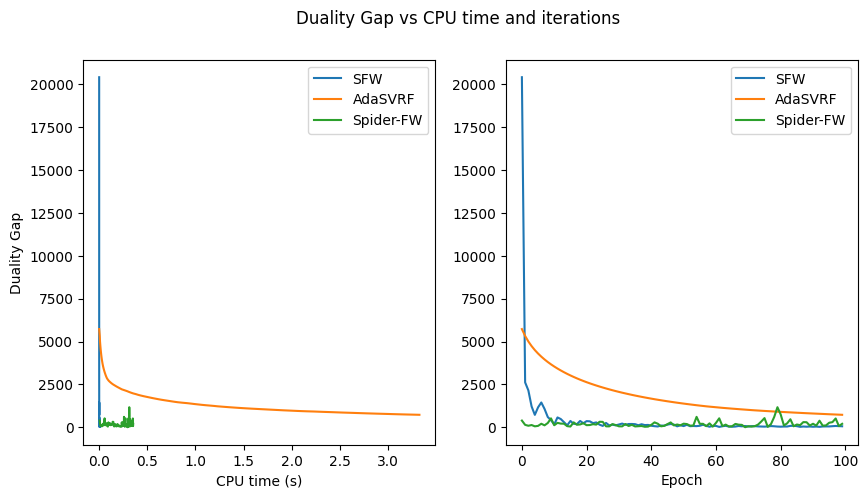

In [ ]:
plotter(times,gaps,'Duality Gap')

## Support Vector Classifier: Breast Cancer Dataset

In [ ]:
# Load the breast cancer dataset
data = datasets.load_breast_cancer()
X = data.data
y = data.target

# Preprocess the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
y[y == 0] = -1 #necessary for the correct classification process

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [ ]:

def f_grad(w):
    grad = np.zeros_like(w)

    for i in range(X_train.shape[0]):
      xi = X_train[i]
      yi = y_train[i]
      if 1 - yi * np.dot(xi, w) > 0:
        grad += -2 * yi * xi * (1 - yi * np.dot(xi, w))

    return grad / X_train.shape[0]

# Define the smoothened hinge loss function
def f_grad_stochastic(w, idx):
    grad = np.zeros_like(w)
    for i in idx:
        xi = X_train[i]
        yi = y_train[i]
        if 1 - yi * np.dot(xi, w) > 0:
            grad += -2 * yi * xi * (1 - yi * np.dot(xi, w))
    return grad / len(idx)

def accuracy_SVC(w):
  y_pred=np.sign(np.dot(X_test,w))
  accuracy=np.mean(y_pred==y_test)
  return accuracy

In [ ]:
d=X_train.shape[1]
n=X_train.shape[0]

In [ ]:
rad = 1
initial_support = sample_l1_ball(d, size=1, radius=rad)
epochs = 100
Kt = int(round(n/25,0))
b = int(np.round(n/10))

sgd_results = sgd(initial_support, epochs, n, b)
sfw_results = SFW(initial_support, epochs, n, Kt, rad)
ada_results = AdaSVRF(m = n,x = initial_support, T=epochs, K = 5, clip = False, radius = rad)
spider_results = SPIDER_FW_ncs(initial_support, epochs, n, rad)

In [ ]:
algs = [sgd_results,sfw_results,ada_results,spider_results]

for i,alg in enumerate(algs):
  print(f"Accuracy {names[i]}: {accuracy_SVC(alg[0])}")

Accuracy SGD: 0.9824561403508771
Accuracy SFW: 0.9473684210526315
Accuracy AdaSVRF: 0.956140350877193
Accuracy Spider-FW: 0.9736842105263158


In [ ]:
for i,alg in enumerate(algs):
  print(f"L1-norm of the parameters for {names[i]}: {np.sum(np.abs(alg[0]))}")

L1-norm of the parameters for SGD: 3.8371722252843274
L1-norm of the parameters for SFW: 0.9604743083003954
L1-norm of the parameters for AdaSVRF: 0.9570190886843853
L1-norm of the parameters for Spider-FW: 1.0


In [ ]:
times = []
gaps = []
algs.pop(0)
for alg in algs:
  times.append(alg[1])
  gaps.append(alg[2])

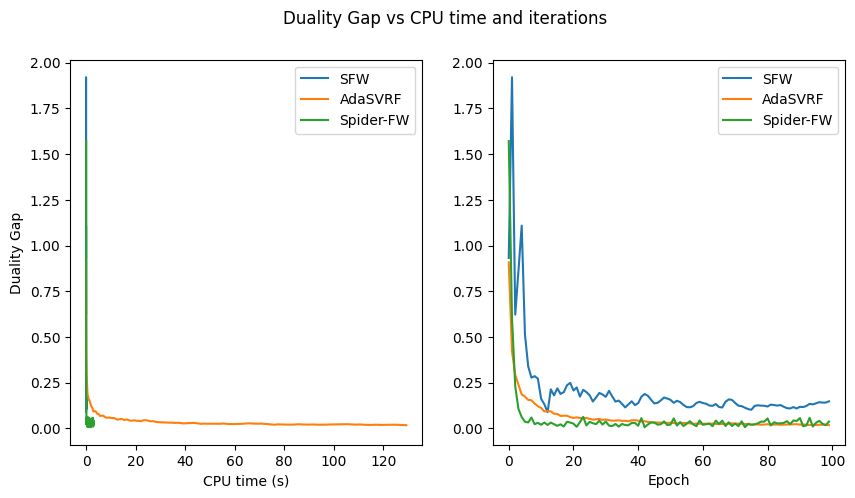

In [ ]:
plotter(times,gaps,'Duality Gap')

# Non-Convex Objectives

## Lasso Logistic Regression: Breast Cancer Dataset

In [ ]:
#Define the loss function and its gradient
def f(w):
    z = X_test.dot(w)
    return np.mean(np.log(1 + np.exp(-y_test * z)))

def f_grad(w):
    z = X_train.dot(w)
    return -(X_train.T.dot(y_train * np.exp(-y_train * z))) / (np.sum(np.exp(-y_train * z)) + 1e-6)

def f_grad_stochastic(w, idx):
    z = X_train[idx].dot(w)
    return -(1/len(idx))*(X_train[idx].T.dot(y_train[idx] * np.exp(-y_train[idx] * z))) / (1+ np.sum(np.exp(-y_train[idx] * z)) + 1e-6)

In [ ]:
def f(w, alpha=0.001):
    z = X_train.dot(w)
    # Add L2 regularization term to the loss function
    return np.mean(np.log(1 + np.exp(-y_train * z))) + alpha * np.sum(np.abs(w))

def f_grad(w, alpha=0.001):
    z = X_train.dot(w)
    # Add L2 regularization term to the gradient
    return -(X_train.T.dot(y_train * np.exp(-y_train * z))) / (np.sum(np.exp(-y_train * z)) + 1e-6) + np.sign(w) * alpha

def f_grad_stochastic(w, idx, alpha=0.001):
    z = X_train[idx].dot(w)
    # Add L2 regularization term to the stochastic gradient
    return -(X_train[idx].T.dot(y_train[idx] * np.exp(-y_train[idx] * z))) / (np.sum(np.exp(-y_train[idx] * z)) + 1e-6) + np.sign(w) * alpha

In [ ]:
def logistic_accuracy(w):
  y_pred_proba = 1 / (1 + np.exp(-X_test.dot(w)))
  y_pred_class = (y_pred_proba > 0.5).astype(int)
  accuracy = np.mean(y_pred_class == y_test)
  return accuracy

In [ ]:
# Load the breast cancer dataset
data = datasets.load_breast_cancer()
X = data.data
y = data.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Set the parameters and run the algorithm
d = X_train.shape[1]
n = X_train.shape[0]

In [ ]:
rad = 100
initial_logistic = sample_l1_ball(d, size=1, radius=rad)
epochs = 100
Kt = int(round(n/25,0))
b = int(np.round(n/10))

sgd_results = sgd(initial_logistic, epochs, n, b)
sfw_results = SFW(initial_logistic, epochs, n, Kt, rad)
ada_results = AdaSVRF(m = n,x = initial_logistic, T=epochs, K = 5, clip = False, radius = rad)
spider_results = SPIDER_FW_ncs(initial_logistic, epochs, n, rad)

In [ ]:
algs = [sgd_results,sfw_results,ada_results,spider_results]

for i,alg in enumerate(algs):
  print(f"Accuracy {names[i]}: {logistic_accuracy(alg[0])}")

Accuracy SGD: 0.07894736842105263
Accuracy SFW: 0.9210526315789473
Accuracy AdaSVRF: 0.08771929824561403
Accuracy Spider-FW: 0.3333333333333333


In [ ]:
for i,alg in enumerate(algs):
  print(f"L1-norm of the parameters for {names[i]}: {np.sum(np.abs(alg[0]))}")

L1-norm of the parameters for SGD: 61.330188386904624
L1-norm of the parameters for SFW: 28.936936936936934
L1-norm of the parameters for AdaSVRF: 73.47378756508782
L1-norm of the parameters for Spider-FW: 70.91079355293614


In [ ]:
times = []
gaps = []
algs.pop(0)
for alg in algs:
  times.append(alg[1])
  gaps.append(alg[2])

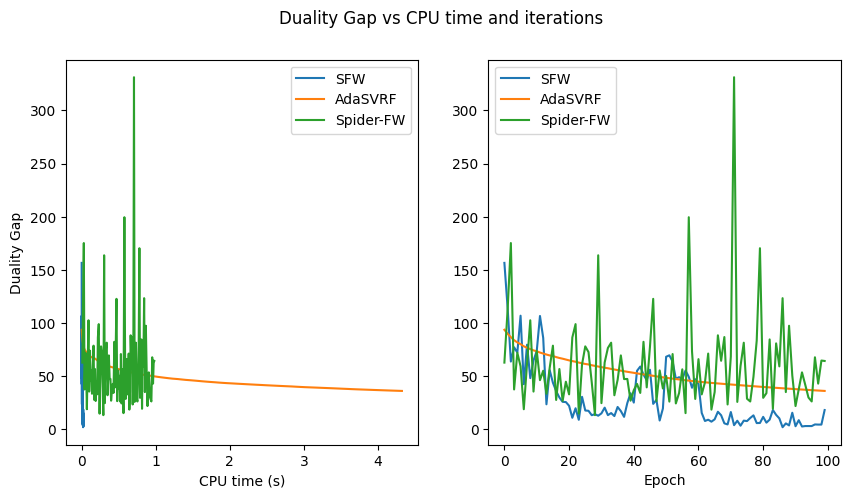

In [ ]:
plotter(times,gaps,'Duality Gap')

## NN: Classification Task

In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def initialize_parameters(n_features, n_hidden, n_output):
    W1_shape = (n_hidden, n_features)
    b1_shape = (n_hidden, 1)
    W2_shape = (n_output, n_hidden)
    b2_shape = (n_output, 1)
    W1 = sample_l1_ball(np.prod(W1_shape), size=1).reshape(W1_shape)
    b1 = sample_l1_ball(np.prod(b1_shape), size=1).reshape(b1_shape)
    W2 = sample_l1_ball(np.prod(W2_shape), size=1).reshape(W2_shape)
    b2 = sample_l1_ball(np.prod(b2_shape), size=1).reshape(b2_shape)
    return np.array([W1, b1, W2, b2],dtype=object)

def forward_propagation(X_train, parameters):
    W1, b1, W2, b2 = parameters[0], parameters[1], parameters[2], parameters[3]
    Z1 = np.dot(W1, X_train.T) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    return np.array([Z1, A1, Z2, A2],dtype=object)

def backward_propagation(X_train, y_train, cache, parameters):
    m = X_train.shape[0]
    Z1, A1, Z2, A2 = cache[0], cache[1], cache[2], cache[3]
    W1, W2 = parameters[0], parameters[2]
    dZ2 = A2 - y_train
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * relu_derivative(Z1)
    dW1 = (1 / m) * np.dot(dZ1, X_train)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    return np.array([dW1, db1, dW2, db2],dtype=object)

def compute_loss(A2, y_train):
    m = y_train.shape[1]
    loss = -np.sum(y_train * np.log(A2) + (1 - y_train) * np.log(1 - A2)) / m
    return np.squeeze(loss)

def f_grad_stochastic(parameters, indices):
    X_mini = X_train[indices, :]
    Y_mini = y_train[:, indices]
    cache = forward_propagation(X_mini, parameters)
    gradients = backward_propagation(X_mini, Y_mini, cache, parameters)
    return gradients

In [ ]:
#lmo for multidimensional weights array v
def lmo(v, radius=1):
    x = [np.zeros_like(v_i) for v_i in v]
    for i in range(len(v)):
        idx1 = np.argmin(v[i])
        idx2 = np.unravel_index(np.argmax(v[i]), v[i].shape)
        if v[i][np.unravel_index(idx1, v[i].shape)] <= -v[i][idx2]:
            x[i][np.unravel_index(idx1, v[i].shape)] = radius
        else:
            x[i][idx2] = -radius
    return x

## Modified Algorithms

In [ ]:
def SGD_NN(x,m,b,T,eta=0.05):

  lr = np.copy(eta)
  time_list = []
  loss_list = []
  acc_list = []

  for t in range(T):
    start = process_time()

    indexes = np.random.randint(low=1, high=m, size=b)
    x = x - eta*f_grad_stochastic(x,indexes)

    eta = lr * (1-(t/T))

    end = process_time()
    time_list.append(end-start)

    f_prop_train= forward_propagation(X_train, x)
    y_train_pred = f_prop_train[3]
    loss_list.append(compute_loss(y_train_pred, y_train))

    f_prop_test = forward_propagation(X_test, x)
    y_test_pred = f_prop_test[3]
    y_test_class = (y_test_pred > 0.5).astype(int)
    acc_list.append(np.mean(y_test_class==y_test))

  return x, time_list, loss_list, acc_list

In [ ]:
def SFW_NN(x_bar_1, T, n, Kt, radius=1):
    times = []
    train_loss = []
    test_acc = []
    x_bar = []
    x_bar.append(x_bar_1)

    for t in range(T):

        start = process_time()

        # Uniformly pick the indices of the units
        Q_t = np.random.choice(n, size=Kt, replace=False)

        # Computes the search direction
        v = f_grad_stochastic(x_bar[t], Q_t)
        w = lmo(v,radius)

        # eta computation
        eta = 2/(t+2)

        # Update the iterate
        x_bar.append(x_bar[t] + eta * (w - x_bar[t]))

        # Performance Evaluations for Graphs

        # cpu time
        end = process_time()
        times.append(end-start)

        # train loss
        f_prop_train= forward_propagation(X_train, x_bar[t+1])
        y_train_pred = f_prop_train[3]
        train_loss.append(compute_loss(y_train_pred, y_train))

        # test accuracy
        f_prop_test = forward_propagation(X_test, x_bar[t+1])
        y_test_pred = f_prop_test[3]
        y_test_class = (y_test_pred > 0.5).astype(int)
        test_acc.append(np.mean(y_test_class==y_test))

    index = np.random.choice(range(T))
    return x_bar[index], times, train_loss, test_acc

In [ ]:
def SPIDER_FW_NN(x_bar_1, T, n):
    x_bar = x_bar_1
    times = []
    train_loss = []
    test_acc = []
    for t in range(0, T):
        start = process_time()
        x = [x_bar]
        Q_t = np.random.choice(n, size=n) # Draw Q_t samples
        v = [f_grad_stochastic(x[0], Q_t)]
        w = [lmo(v[0])]
        Kt_func= lambda t: math.ceil(n**0.5) # size of the minibatch (?)
        Kt = Kt_func(t)
        eta = math.sqrt(1 / (T * Kt))
        x.append(x[0] + eta * (w[0] - x[0]))
        for k in range(1, Kt):
            S_t_k = np.random.choice(n, size=math.ceil(n**0.5), replace=True) # Draw S_t_k samples
            v.append(f_grad_stochastic(x[k], S_t_k) - f_grad_stochastic(x[k-1], S_t_k) + v[k-1])
            w.append(lmo(v[k]))
            x.append(x[k] + eta * (w[k] - x[k]))
        x_bar = x[-1] #use the last value to continue the optimization on next iter
        # Performance Evaluations for Graphs

        # cpu time
        end = process_time()
        times.append(end-start)

        # train loss
        f_prop_train= forward_propagation(X_train, x_bar)
        y_train_pred = f_prop_train[3]
        train_loss.append(compute_loss(y_train_pred, y_train))

        # test accuracy
        f_prop_test = forward_propagation(X_test, x_bar)
        y_test_pred = f_prop_test[3]
        y_test_class = (y_test_pred > 0.5).astype(int)
        test_acc.append(np.mean(y_test_class==y_test))

    return x_bar, times, train_loss, test_acc

### Modified AdaSVRF

In [ ]:
#lmo for multidimensional weights array v
def lmo_ADA(v, radius=1):
    x = np.zeros_like(v)
    for i in range(len(v)):
        idx1 = np.argmin(v[i])
        idx2 = np.unravel_index(np.argmax(v[i]), v[i].shape)
        if v[i][np.unravel_index(idx1, v[i].shape)] <= -v[i][idx2]:
            x[i][np.unravel_index(idx1, v[i].shape)] = radius
        else:
            x[i][idx2] = -radius
    return x

In [ ]:
def forward_propagation_ADA(X_train, parameters):
    W1, b1, W2, b2 = parameters[0], parameters[1], parameters[2], parameters[3]
    Z1 = np.dot(W1, X_train.T) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    return np.array([Z1, A1, Z2, A2],dtype=object)

def backward_propagation_ADA(X_train, y_train, cache, parameters):
    m = X_train.shape[0]
    Z1, A1, Z2, A2 = cache[0], cache[1], cache[2], cache[3]
    W1, W2 = parameters[0], parameters[2]
    dZ2 = A2 - y_train
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * relu_derivative(Z1)
    dW1 = (1 / m) * np.dot(dZ1, X_train)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    return np.array([dW1, db1, dW2, db2],dtype=object)

def compute_loss_ADA(A2, y_train):
    m = y_train.shape[1]
    loss = -np.sum(y_train * np.log(A2) + (1 - y_train) * np.log(1 - A2)) / m
    return np.squeeze(loss)

def f_grad_ADA(parameters):
  cache = forward_propagation(X_train, parameters)
  gradients = backward_propagation(X_train, y_train, cache, parameters)
  return gradients

def f_grad_stochastic_ADA(parameters, indices):
    X_mini = X_train[indices, :]
    Y_mini = y_train[:, indices]
    cache = forward_propagation(X_mini, parameters)
    gradients = backward_propagation(X_mini, Y_mini, cache, parameters)
    return gradients

In [ ]:
def update_H_NN(l):

  H = np.zeros(len(l[0]))

  for element in l:
    for j in range(len(element)):
      H[j] = H[j] + np.sqrt(np.sum(np.square(element[j])))

  return H


In [ ]:
def AdaSVRF_NN(m,x,T,K):

  H = 0
  grad_list = []
  time_list = []
  train_loss= []
  test_acc = []

  x_prev = np.copy(x)

  for t in range(T):

    start = process_time()

    step = compute_step(t)

    if(check_t(t)):
      x_hat = np.copy(x)
      grad = f_grad_ADA(x_hat)
      snapshot = np.copy(grad)
    else:
      x_hat = np.copy(x_prev)

      b = compute_bt(t,K)
      indexes = np.random.randint(low=1, high=m, size=b)

      grad = snapshot + f_grad_stochastic_ADA(x,indexes) - f_grad_stochastic_ADA(x_hat,indexes)

    x_prev = np.copy(x_hat)

    grad_list.append(grad)

    H = update_H_NN(grad_list)

    rate = compute_rate(t)
    step = compute_step(t)

    y = np.copy(x)

    for k in range(K):

      for i,parameter in enumerate(x_hat):

        Q = grad[i] + (1/rate) * H[i] * (y[i]-x[i])

        v = lmo_ADA(Q)

        # This is done to avoid the repetition of the computation
        diff = y[i]-v

        step = np.min([step, np.dot(Q.flatten(),diff.flatten())/(np.dot(diff.flatten(),H[i]*diff.flatten())+0.000001)])

        # Here - and not + beacause (v-y) = -(y-v)
        y[i] = y[i] - step*diff

    x = np.copy(y)

    end = process_time()
    time_list.append(end-start)

    # train loss
    f_prop_train= forward_propagation_ADA(X_train, x)
    y_train_pred = f_prop_train[3]
    train_loss.append(compute_loss_ADA(y_train_pred, y_train))

    # test accuracy
    f_prop_test = forward_propagation_ADA(X_test, x)
    y_test_pred = f_prop_test[3]
    y_test_class = (y_test_pred > 0.5).astype(int)
    test_acc.append(np.mean(y_test_class==y_test))

  return x, time_list, train_loss, test_acc

## Task

In [ ]:
# Load the breast cancer dataset
data = datasets.load_breast_cancer()
X = data.data
y = data.target

scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

n_features = X_train.shape[1]
n_hidden = 2  # Number of neurons in the hidden layer
n_output = 1  # Number of output neurons (binary classification)
n = X_train.shape[0]

parameters = initialize_parameters(n_features, n_hidden, n_output)
print("Gradients shapes initial:", [grad.shape for grad in parameters])

Gradients shapes initial: [(2, 30), (2, 1), (1, 2), (1, 1)]


In [ ]:
rad = 1
initial_support = sample_l1_ball(n_features, size=1, radius=rad)
epochs = 3*100
Kt = int(round(n/25,0))
b = int(np.round(n/10))

sgd_results = SGD_NN(parameters, n, b, epochs)
sfw_results = SFW_NN(parameters, epochs, n, Kt, rad)
ada_results = AdaSVRF_NN(m = n,x = parameters, T=epochs, K = 5)
spider_results = SPIDER_FW_NN(parameters, epochs, n)

<ipython-input-47-7eadc06c39d8>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_bar.append(x_bar[t] + eta * (w - x_bar[t]))
<ipython-input-48-15b683cce4b1>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x.append(x[0] + eta * (w[0] - x[0]))
<ipython-input-48-15b683cce4b1>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x.app

In [ ]:
def accuracy_NN(w):
  cache = forward_propagation(X_test, w)
  predictions = cache[3]

  binary_predictions = (predictions > 0.5).astype(int)

  accuracy=np.mean(binary_predictions==y_test)

  return accuracy


In [ ]:
algs = [sgd_results,sfw_results,ada_results,spider_results]

for i,alg in enumerate(algs):
  print(f"Accuracy {names[i]}: {accuracy_NN(alg[0])}")

Accuracy SGD: 0.9385964912280702
Accuracy SFW: 0.8771929824561403
Accuracy AdaSVRF: 0.9035087719298246
Accuracy Spider-FW: 0.9122807017543859


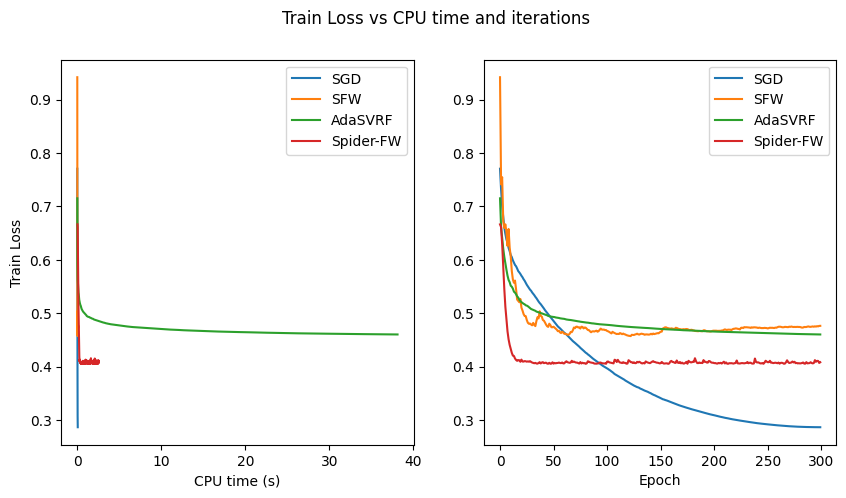

In [ ]:
times = []
losses = []
for alg in algs:
  times.append(alg[1])
  losses.append(alg[2])
plotter(times,losses,'Train Loss',names)

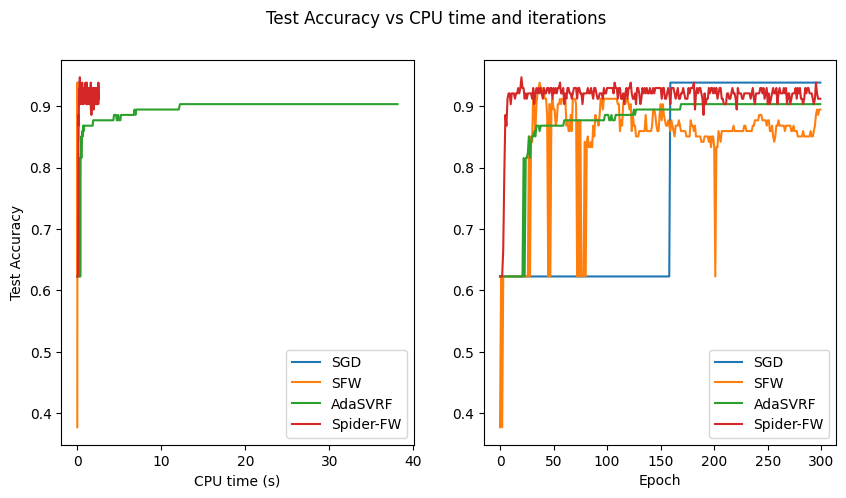

In [ ]:
times = []
accs = []
for alg in algs:
  times.append(alg[1])
  accs.append(alg[3])
plotter(times,accs,'Test Accuracy',names)

## CNN: Classification Task

### Data and CNN initialisations

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define the transform to normalize the data
def MinMaxScaler(img):
  img_as_array = np.asarray(img)
  img_as_tensor = torch.tensor(img_as_array)
  img_as_tensor = torch.permute(img_as_tensor, (2,0,1))
  return img_as_tensor.to(torch.float)/255

# Load the CIFAR-10 dataset
cifar_train = CIFAR10(root='./data', train=True, download=True,
                      transform=transforms.Lambda(MinMaxScaler))
cifar_test = CIFAR10(root='./data', train=False, download=True,
                     transform=transforms.Lambda(MinMaxScaler))

# Define the size of the validation set (i.e., 40 000 units)
val_size = int(0.8 * len(cifar_train))
train_size = len(cifar_train) - val_size

# Split the training data into a training set and a validation set
train_set, val_set = random_split(cifar_train, [train_size, val_size])

# Create Data Loaders
sampler = RandomSampler(train_set, replacement=True)
batch_size = math.ceil(np.sqrt(len(cifar_train)))

train_loader_sqrt = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=sampler)
train_loader_n = torch.utils.data.DataLoader(train_set, batch_size=int(len(cifar_train)), sampler=sampler)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=512, shuffle=False)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=512, shuffle=False)

In [ ]:
class my_cnn(nn.Module):
    def __init__(self, num_kernels = [], kernel_sizes=[], max_pool_sizes=[], act_funs=[]):
        super().__init__()

        # Check in the conditions are met (one condition per layer)
        assert len(num_kernels) == len(kernel_sizes), "ERROR. Length of {num_kernels} and {kernel_sizes} must be the same"
        assert len(num_kernels) == len(max_pool_sizes), "ERROR. Length of {num_kernels} and {max_pool_sizes} must be the same"
        assert len(num_kernels) == len(act_funs), "ERROR. Length of {num_kernels} and {act_fun} must be the same"

        self.conv_layers = nn.ModuleList()
        self.max_pools = nn.ModuleList()
        self.act_funs = act_funs

        # Build the NN
        for layer in range(len(num_kernels)):

            if layer == 0:
                self.conv_layers = self.conv_layers.append(nn.Conv2d(
                in_channels=3,
                out_channels=num_kernels[layer],
                kernel_size=kernel_sizes[layer],
                stride=1,
                padding="same"))

            else:
                self.conv_layers = self.conv_layers.append(nn.Conv2d(
                in_channels=num_kernels[layer-1],
                out_channels=num_kernels[layer],
                kernel_size=kernel_sizes[layer],
                stride=1,
                padding="same"))

            self.max_pools = self.max_pools.append(nn.MaxPool2d(
                max_pool_sizes[layer]))

            height_dimension = 32
            width_dimension = 32

            for maxp1, maxp2 in max_pool_sizes:
                height_dimension = height_dimension // maxp1
                width_dimension = width_dimension // maxp2

            self.linear = Linear(num_kernels[-1] * height_dimension * width_dimension, 10)

    # Define the forward function
    def forward(self, x):
        weight_type = self.conv_layers[0].weight.dtype
        x = x.to(weight_type)
        x = x.to('cuda')
        for layer in range(len(self.conv_layers)):
            current_conv_layer = self.conv_layers[layer]
            current_max_pool = self.max_pools[layer]
            current_act_fun = self.act_funs[layer]
            x = current_max_pool(current_act_fun(current_conv_layer(x)))

        x = torch.flatten(x, start_dim=1)

        return  self.linear(x)

In [ ]:
# CNN parameters initialisation
num_kernels = [32,16]
kernel_sizes = [[3,3],[2,2]]
max_pool_sizes = [[3,3],[3, 3]]
act_funs = [F.relu,F.relu]

# Epochs and criterion initialisation
T = 100
criterion = nn.CrossEntropyLoss()

In [ ]:
# Weights initialisation
model_sgd = my_cnn(num_kernels, kernel_sizes, max_pool_sizes, act_funs).to(device)
x_bar_place = sample_l1_ball(d=sum(p.numel() for p in model_sgd.parameters()),size=1,radius=100)

### Other shared functions

In [ ]:
def weight_initialiser(model, x_bar):
  start_index = 0
  for param in model.parameters():
    shape = param.data.shape
    size = torch.prod(torch.tensor(shape)).item()
    flat_param = x_bar_place[:,start_index:start_index+size]
    param.data = torch.tensor(flat_param).reshape(shape).to(device)

In [ ]:
# If verbose == True --> return accuracy and loss
def forward_and_back(model, data, verbose, retain_graph):

  # Check if verbose = True or False
  assert type(verbose) == bool, "ERROR - 'verbose' can be only True or False"

  # Data separation in X and y
  X, y = data
  X, y = X.to(device), y.to(device)

  # Model's gradient equal to zero
  model.zero_grad()

  # Propagate forward the input, compute the loss
  logits = model(X)
  loss = criterion(logits, y)
  loss_item = loss.item()

  # Condition necessary for backpropagate in Spider
  if retain_graph == True:
    loss.backward(retain_graph=True)
  else:
    loss.backward()

  # If requested, return the accuracy and the loss
  if verbose == True:
    predicted_labels = torch.argmax(logits, dim=1)
    accuracy = (predicted_labels == y).float().mean()
    return float(accuracy), (loss_item)

In [ ]:
# If verbose == True --> return accuracy and loss
def evaluation(model, data):

  # Data separation in X and y
  X, y = data
  X, y = X.to(device), y.to(device)

  # Propagate forward the input, compute the loss
  logits = model(X)
  loss = criterion(logits, y)
  loss_item = loss.item()

  # Compute accuracy
  predicted_labels = torch.argmax(logits, dim=1)
  accuracy = (predicted_labels == y).float().mean()
  return float(accuracy), float(loss_item)

### CNN SGD

In [ ]:
def SGD_x_CNN(model, T):
  tr_loss_l, tr_acc_l = [], []
  val_loss_l, val_acc_l = [], []
  times = []
  eta = 0.05

  # --- Training section ---
  for t in range(T):
    start = process_time()
    model.train()
    acc_subl, loss_subl = [], []
    for i, data in enumerate(train_loader_sqrt):
      # Forward and backpropagation
      acc, loss = forward_and_back(model, data, True, False)
      acc_subl.append(acc), loss_subl.append(acc)
      # Parameters update
      with torch.no_grad():
        for param in model.parameters():
          param.data -= eta * param.grad
      eta -= eta / (T+1)
    # Training and loss accuracy at epoch t
    tr_loss_l.append(np.mean(loss_subl)), tr_acc_l.append(np.mean(acc_subl))
    end = process_time()
    times.append(end-start)

  # --- Validation section ---
    with torch.no_grad():
      model.eval()
      acc_subl, loss_subl = [], []
      for i, data in enumerate(val_loader):
        acc, loss_item = evaluation(model, data)
        acc_subl.append(acc), loss_subl.append(loss_item)
      val_loss_l.append(np.mean(loss_subl)), val_acc_l.append(np.mean(acc_subl))

  return model.parameters(), tr_loss_l, tr_acc_l, val_loss_l, val_acc_l, times

In [ ]:
weight_initialiser(model_sgd, x_bar_place)
sgd_x, sgd_tr_loss, sgd_tr_acc, sgd_val_loss, sgd_val_acc, sgd_times = SGD_x_CNN(model_sgd, T)

### CNN SFW

In [ ]:
def SFW_x_CNN(model, T):
  x_bar = []
  tr_loss_l, tr_acc_l = [], []
  val_loss_l, val_acc_l = [], []
  times = []

  # --- Training section ---
  for t in range(T):
    start = process_time()
    x_bar.append(model.parameters())
    model.train()
    acc_subl, loss_subl = [], []
    for i, data in enumerate(train_loader_sqrt):
      # Forward and backpropagation
      acc, loss = forward_and_back(model, data, True, False)
      acc_subl.append(acc), loss_subl.append(acc)
      # Parameters update
      eta = 2/(t+2)
      with torch.no_grad():
        for param in model.parameters():
          w = lmo(param.grad.clone(),radius=100)
          w = torch.from_numpy(w).to(param.device)
          param.data += eta * (w - param.data)
    # Training and loss accuracy at epoch t
    tr_loss_l.append(np.mean(loss_subl)), tr_acc_l.append(np.mean(acc_subl))
    end = process_time()
    times.append(end-start)

  # --- Validation section ---
    with torch.no_grad():
      model.eval()
      acc_subl, loss_subl = [], []
      for i, data in enumerate(val_loader):
        acc, loss_item = evaluation(model, data)
        acc_subl.append(acc), loss_subl.append(loss_item)
      val_loss_l.append(np.mean(loss_subl)), val_acc_l.append(np.mean(acc_subl))

  # Return a random xt
  x_bar.append(model.parameters())
  idx = np.random.randint(0, T+1)
  return x_bar[idx], tr_loss_l, tr_acc_l, val_loss_l, val_acc_l, times

In [ ]:
model_sfw = my_cnn(num_kernels, kernel_sizes, max_pool_sizes, act_funs).to(device)
weight_initialiser(model_sfw, x_bar_place)
sfw_x, sfw_tr_loss, sfw_tr_acc, sfw_val_loss, sfw_val_acc, sfw_times = SFW_x_CNN(model_sfw, T)

### CNN SPIDER-FW

In [ ]:
def SPIDER_FW_x_CNN(model, T):
  tr_loss_l, tr_acc_l = [], []
  val_loss_l, val_acc_l = [], []
  times = []
  # Initialise v_prev and vk as tensors of the same dimension of the
  # parameters, filled with zeros
  v_prev, vk = [], []
  K = math.ceil(np.sqrt(len(cifar_train)))
  eta = np.sqrt(T*K)**(-1)
  for param in model.parameters():
    v_prev.append(torch.zeros_like(param))
    vk.append(torch.zeros_like(param))

  # --- Training section ---
  for t in range(T):
    start = process_time()
    acc_subl, loss_subl = [], []
    # Initialise model_prev with the values at the end of the previous epochs,
    # i.e., x1
    model_prev = my_cnn(num_kernels, kernel_sizes, max_pool_sizes, act_funs).to(device)
    model_prev.load_state_dict(model.state_dict())
    model.train()
    model_prev.train()

    # - Operations before the inner loop -
    # Generate Qt of size n with replacement
    train_loader_n = torch.utils.data.DataLoader(train_set, batch_size=len(cifar_train), sampler=sampler)
    for i, data in enumerate(train_loader_n):
      # Forward and backpropagation of model
      forward_and_back(model, data, False, False)
      # Parameters update
      with torch.no_grad():
        for i, param in enumerate(model.parameters()):
          v_prev[i] = param.grad.clone()
          w = lmo(param.grad.clone(),radius=100)
          w = torch.from_numpy(w).to(param.device)
          param.data += eta * (w - param.data)

    # - Inner loop -
    for k in range(1,K):
      # Generate S of size sqrt(n) with replacement
      batch_size = math.ceil(np.sqrt(len(cifar_train)))
      train_loader_sqrt = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=sampler)
      for i, data in enumerate(train_loader_sqrt):
        # Forward and backpropagation of model (i.e., xk)
        forward_and_back(model, data, False, True)
        # Forward and backpropagation of model_prev (i.e., x(k-1))
        forward_and_back(model_prev, data, False, False)
        # Update of model parameters
        with torch.no_grad():
          for i, (param_k, param_prev) in enumerate(zip(model.parameters(), model_prev.parameters())):
            vk[i] = param_k.grad.clone() - param_prev.grad.clone() + v_prev[i]
            v_prev[i] = vk[i]
            # Initialise model_prev with the same parameters of model, to
            # to compute at the next iteration the gradient w.r.t x(k-1)
            model_prev = my_cnn(num_kernels, kernel_sizes, max_pool_sizes, act_funs).to(device)
            model_prev.load_state_dict(model.state_dict())
            # Computation of w and update
            w = lmo(vk[i],radius=100)
            w = torch.from_numpy(w).to(param.device)
            param_k.data += eta * (w - param_k.data)
      break # as SPIDER-FW needs to pass only one batch of dimension sqrt(n)

    # - Training metrics computation -
    with torch.no_grad():
      model.eval()
      model_prev.eval()
      acc_subl, loss_subl = [], []
      for i, data in enumerate(train_loader_sqrt):
        acc, loss_item = evaluation(model, data)
        acc_subl.append(acc), loss_subl.append(loss_item)
      tr_loss_l.append(np.mean(loss_subl)), tr_acc_l.append(np.mean(acc_subl))
      end = process_time()
      times.append(end-start)

  # --- Validation section ---
    with torch.no_grad():
      acc_subl, loss_subl = [], []
      for i, data in enumerate(val_loader):
        acc, loss_item = evaluation(model, data)
        acc_subl.append(acc), loss_subl.append(loss_item)
      val_loss_l.append(np.mean(loss_subl)), val_acc_l.append(np.mean(acc_subl))

  return model.parameters(), tr_loss_l, tr_acc_l, val_loss_l, val_acc_l, times


In [ ]:
model_spider= my_cnn(num_kernels, kernel_sizes, max_pool_sizes, act_funs).to(device)
weight_initialiser(model_spider, x_bar_place)
spider_x, spider_tr_loss, spider_tr_acc, spider_val_loss, spider_val_acc, spider_times = SPIDER_FW_x_CNN(model_spider, T)

### Evaluation

In [ ]:
names = ['SGD', 'SFW', 'Spider-FW']
final_tr_loss = [sgd_tr_loss, sfw_tr_loss, spider_tr_loss]
final_val_acc = [sgd_val_acc, sfw_val_acc, spider_val_acc]
final_times = [sgd_times, sfw_times, spider_times]

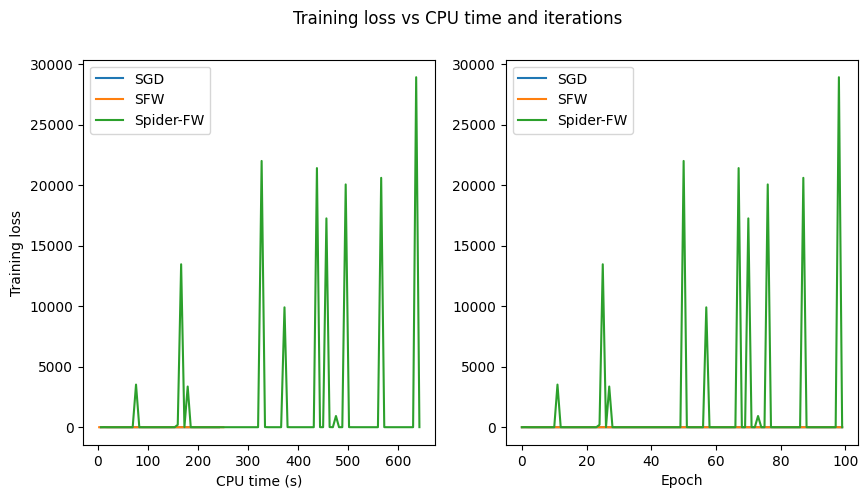

In [ ]:
plotter(final_times,final_tr_loss,'Training loss',names)

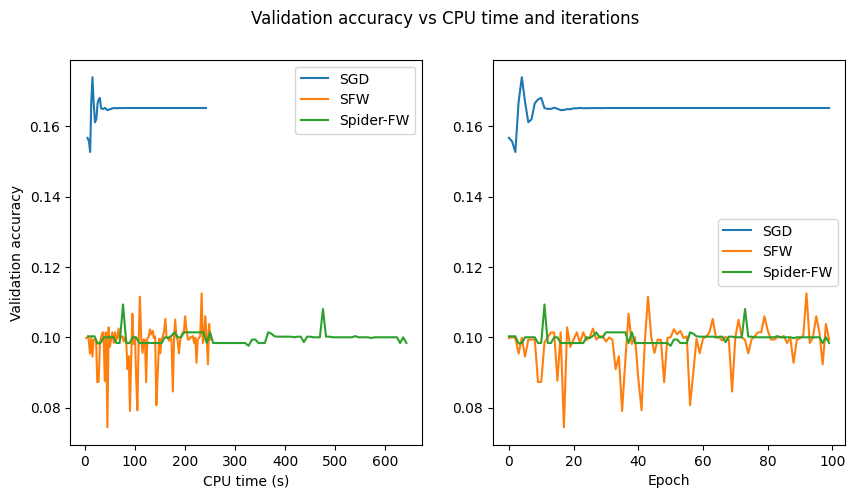

In [ ]:
plotter(final_times,final_val_acc,'Validation accuracy',names)